In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import re

In [3]:
def custom_tokenizer(text):
    # Define patterns for common tokens
    patterns = [
        r"\w+",            # Word tokens
        r"\d+",            # Numeric tokens
        r"\S+"             # Other tokens (non-whitespace)
    ]
    
    # Join patterns with the "|" operator to create a single regex pattern
    pattern = "|".join(patterns)
    
    # Use the regex pattern to tokenize the text
    tokens = re.findall(pattern, text)
    
    tokens = [token.lower() for token in tokens]
    
    return tokens


In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold # Minimum frequency for a word to be included in the vocabulary

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.lower() for tok in custom_tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [5]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [6]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [7]:
TRAIN_RATIO = 0.7
TEST_RATIO = 0.15
VAL_RATIO = 0.15

BATCH_SIZE = 64
WORKERS = 6


In [8]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=64,
    num_workers=6,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    total_samples = len(dataset)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    train_size = int(TRAIN_RATIO * total_samples)
    val_size = int(TEST_RATIO * total_samples)
    test_size = total_samples - (train_size + val_size)

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    
    val_loader = DataLoader(
        dataset=val_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    
    test_loader = DataLoader(
        dataset=test_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return train_loader, val_loader, test_loader, dataset

In [9]:
transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor(),]
    )

train_loader, val_loader, test_loader, dataset = get_loader(
        "../Data/Images/", "../Data/captions.txt", transform=transform
    )


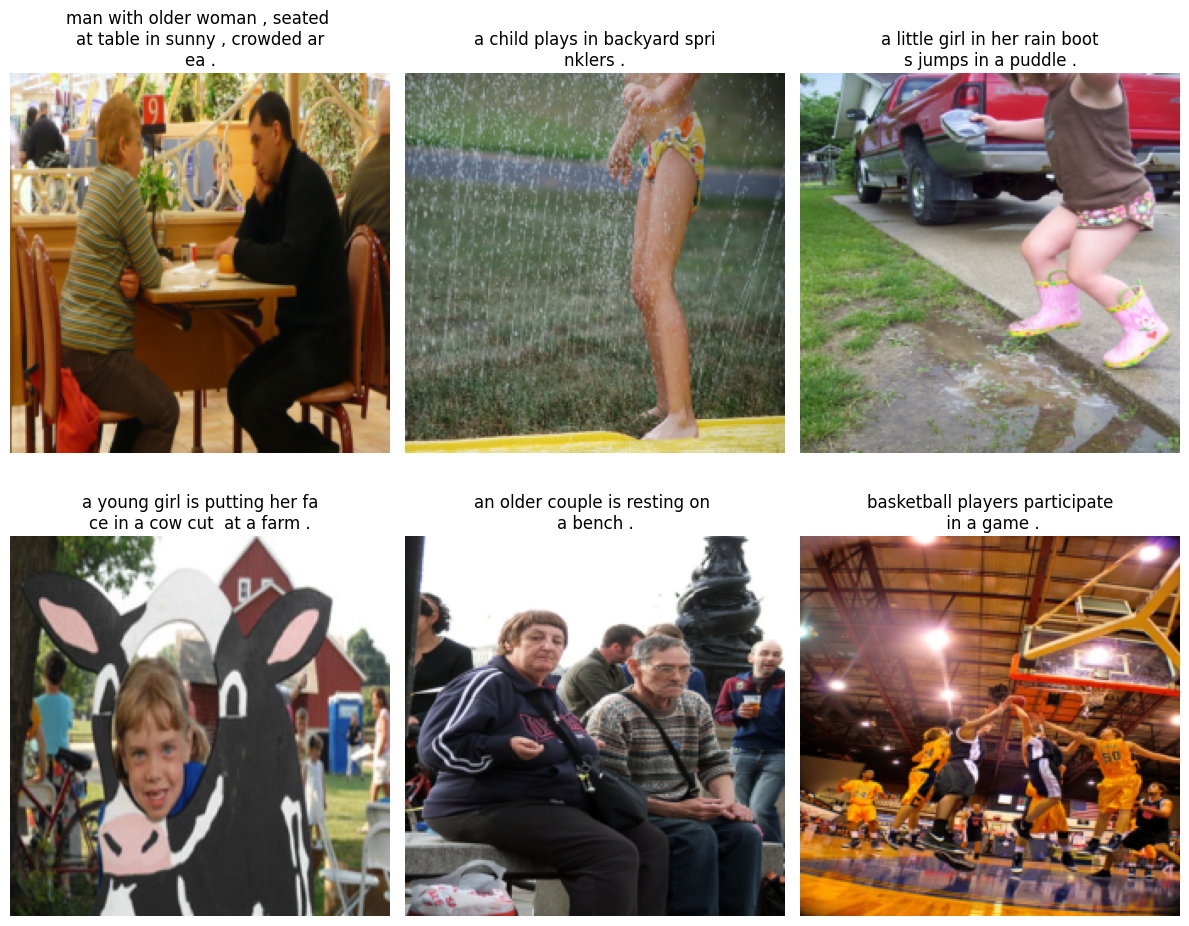

In [10]:
image, caption = dataset[1]

not_needed = ['<SOS>','<EOS>','<UNK>']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
axes = axes.ravel()

for i in range(6):
    index = torch.randint(len(dataset), size=(1,)).item()
    image, caption = dataset[index]
    image = image.numpy().transpose((1, 2, 0))
    sentence=" ".join(dataset.vocab.itos[wrd_emb] if dataset.vocab.itos[wrd_emb] not in not_needed else "" 
                      for wrd_emb in caption.numpy()).strip()
    caption_lines = [sentence[j:j + 30] for j in range(0, len(sentence), 30)]
    formatted_caption = '\n'.join(caption_lines)
    
    axes[i].imshow(image)
    axes[i].set_title(f"{formatted_caption}")
    axes[i].axis('off')

# plt.tight_layout()
plt.tight_layout()
plt.show()